In [105]:
import pandas as pd
from sklearn.decomposition import PCA
import numpy as np
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn import cluster
import seaborn as sns
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', 500)
from sklearn.preprocessing import StandardScaler

#read train players cleaned
train_player_cleaned = pd.read_csv('../Player-Clustering/train_players_cleaned.csv')

#read test players cleaned
test_player_cleaned = pd.read_csv('../Player-Clustering/test_players_cleaned.csv')

#read train player cluster
train_player_clustered = pd.read_csv('../Player-Clustering/train_players_clustered.csv')

#read test player cluster
test_player_clustered = pd.read_csv('../Player-Clustering/test_players_clustered.csv')

#read train team cleaned
train_teams = pd.read_csv('train_teams_cleaned.csv')

#read test team cleaned
test_teams = pd.read_csv('test_teams_cleaned.csv')


# #read players_cleaned
# players_cleaned = pd.read_csv('../Player-Clustering/players_cleaned.csv')

# #read players_clustered
# players_clustered = pd.read_csv('../Player-Clustering/players_clustered.csv')

#read team_cleaned
# cleaned_team = pd.read_csv('teams_cleaned.csv')

In [106]:
test_player_cleaned.head()

,Unnamed: 0,Player_x,Pos_x,Age_x,Tm_x,G_x,GS,MP_x,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,ORtg,DRtg,Player_year,Year,PER,TS%,3PAr,FTr,ORB%,DRB%,TRB%,AST%,STL%,BLK%,TOV%,USG%,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP,All-Star_caliber,Abrv,Team_full
0,0,Alex Abrines\abrinal01,SG,25,OKC,31,2,588,4.4,12.5,0.357,3.3,10.1,0.323,1.2,2.4,0.500,1.0,1.0,0.923,0.4,3.4,3.8,1.6,1.3,0.5,1.1,4.2,13.1,103.0,111,Alex Abrines\abrinal01/2019,2019,6.3,0.507,0.809,0.083,0.9,7.8,4.2,4.3,1.3,0.9,7.9,12.2,0.1,0.6,0.6,0.053,-2.4,-0.9,-3.4,-0.2,0,OKC,Oklahoma City Thunder/2019
1,1,Steven Adams\adamsst01,C,25,OKC,80,80,2669,8.4,14.1,0.595,0.0,0.0,0.000,8.4,14.1,0.596,2.6,5.1,0.500,6.8,6.5,13.3,2.2,2.0,1.3,2.4,3.6,19.4,120.0,106,Steven Adams\adamsst01/2019,2019,18.5,0.591,0.002,0.361,14.7,14.8,14.7,6.6,2.0,2.4,12.6,16.4,5.1,4.0,9.1,0.163,0.6,2.1,2.7,3.2,1,OKC,Oklahoma City Thunder/2019
2,2,Deonte Burton\burtode02,SG,25,OKC,32,0,240,6.4,15.9,0.402,1.6,5.3,0.296,4.9,10.7,0.455,1.6,2.3,0.667,0.8,4.7,5.4,1.8,1.2,1.6,1.8,6.0,15.9,94.0,109,Deonte Burton\burtode02/2019,2019,7.0,0.470,0.329,0.146,1.7,10.7,6.0,5.0,1.2,2.8,9.3,16.3,-0.2,0.3,0.1,0.027,-5.6,-0.6,-6.3,-0.3,0,OKC,Oklahoma City Thunder/2019
3,3,Tyler Davis\davisty01,C,21,OKC,1,0,1,0.0,46.7,0.000,0.0,0.0,0.000,0.0,46.7,0.000,0.0,0.0,0.000,46.7,0.0,46.7,0.0,0.0,0.0,0.0,0.0,0.0,65.0,116,Tyler Davis\davisty01/2019,2019,0.0,0.000,0.000,0.000,100.0,0.0,51.6,0.0,0.0,0.0,0.0,40.7,0.0,0.0,0.0,-0.471,-15.0,-20.5,-35.5,0.0,0,OKC,Oklahoma City Thunder/2019
4,4,Hamidou Diallo\diallha01,SG,20,OKC,51,3,526,6.7,14.6,0.455,0.4,2.1,0.167,6.3,12.5,0.504,3.2,5.2,0.610,3.4,5.2,8.6,1.5,1.9,0.9,2.0,6.8,16.9,103.0,108,Hamidou Diallo\diallha01/2019,2019,10.1,0.497,0.145,0.358,7.2,12.0,9.5,4.4,1.9,1.6,10.7,16.6,0.1,0.7,0.8,0.069,-4.3,-0.3,-4.7,-0.4,0,OKC,Oklahoma City Thunder/2019


In [107]:
#Take out TOT rows, only keep team rows

train_players = train_player_cleaned.loc[train_player_cleaned['Tm_x'] != 'TOT']
test_players = test_player_cleaned.loc[test_player_cleaned['Tm_x'] != 'TOT']

#players = players_cleaned.loc[players_cleaned['Tm_x'] != 'TOT']

#TODO Need to sort on Minutes and only take top 9 per team...
#get set of teams
#for each team in set of teams take top 9s rows of df sorted on min

#TRAIN
players_by_team_min = train_players.sort_values(['Team_full', 'MP_x'], ascending=[True, False])
train_top9 = pd.DataFrame()
teams = set(train_players['Team_full'])

for i in teams:
    team_df = players_by_team_min[players_by_team_min['Team_full']==i]
    train_top9 = train_top9.append(team_df.iloc[:9,:], ignore_index=True)

#only keep player and team
train_players = train_top9[['Player_year','Team_full']]

#only keep player and cluster
train_players_cluster = train_player_clustered[['Player_year', 'Cluster']]

train_player_team_cluster = train_players.merge(train_players_cluster, left_on = 'Player_year', right_on = 'Player_year', how = 'left')

#TEST
players_by_team_min = test_players.sort_values(['Team_full', 'MP_x'], ascending=[True, False])
test_top9 = pd.DataFrame()
teams = set(test_players['Team_full'])

for i in teams:
    team_df = players_by_team_min[players_by_team_min['Team_full']==i]
    test_top9 = test_top9.append(team_df.iloc[:9,:], ignore_index=True)

#only keep player and team
test_players = test_top9[['Player_year','Team_full']]

#only keep player and cluster
test_players_cluster = test_player_clustered[['Player_year', 'Cluster']]

test_player_team_cluster = test_players.merge(test_players_cluster, left_on = 'Player_year', right_on = 'Player_year', how = 'left')


In [108]:
test_player_team_cluster.head()

,Player_year,Team_full,Cluster
0,Jayson Tatum\tatumja01/2019,Boston Celtics/2019,Primary Distributing Ballhandler
1,Kyrie Irving\irvinky01/2019,Boston Celtics/2019,Pace & Space Forward
2,Marcus Smart\smartma01/2019,Boston Celtics/2019,Defensive Forward
3,Marcus Morris\morrima03/2019,Boston Celtics/2019,Primary Distributing Ballhandler
4,Al Horford\horfoal01/2019,Boston Celtics/2019,3 & D Wing


In [109]:
#Create roster composition counts for each team

train_cluster_dummies = pd.get_dummies(train_player_team_cluster['Cluster'])
test_cluster_dummies = pd.get_dummies(test_player_team_cluster['Cluster'])

train_cluster_dummies['Team'] = train_player_team_cluster['Team_full']
test_cluster_dummies['Team'] = test_player_team_cluster['Team_full']

train_roster_composition = train_cluster_dummies.groupby(['Team']).sum()
test_roster_composition = test_cluster_dummies.groupby(['Team']).sum()


In [110]:
test_roster_composition.head()

,3 & D Wing,Combo Guard,Defensive Forward,Offensive Big Man,Pace & Space Forward,Post-Heavy Big Man,Primary Distributing Ballhandler,Slashing Guard
Team,,,,,,,,
Atlanta Hawks/2019,0,1,2,0,0,1,5,0
Boston Celtics/2019,2,0,3,0,1,0,3,0
Brooklyn Nets/2019,0,2,1,2,1,1,2,0
Charlotte Hornets/2019,0,0,0,0,0,0,0,0
Chicago Bulls/2019,2,0,1,0,2,1,3,0


In [111]:
#add some team stats to roster composition
train_roster_composition = pd.DataFrame(train_roster_composition)
train_roster_composition['Team'] = train_roster_composition.index

train_team_stats = train_teams[['Team_year','3PAr', 'FTr', 'Pace']]
train_ros_comp_team_stats = train_roster_composition.merge(train_team_stats, left_on='Team', right_on='Team_year')

test_roster_composition = pd.DataFrame(test_roster_composition)
test_roster_composition['Team'] = test_roster_composition.index

test_team_stats = test_teams[['Team_year','3PAr', 'FTr', 'Pace']]
test_ros_comp_team_stats = test_roster_composition.merge(test_team_stats, left_on='Team', right_on='Team_year')


In [112]:
test_ros_comp_team_stats.head()

,3 & D Wing,Combo Guard,Defensive Forward,Offensive Big Man,Pace & Space Forward,Post-Heavy Big Man,Primary Distributing Ballhandler,Slashing Guard,Team,Team_year,3PAr,FTr,Pace
0,0,1,2,0,0,1,5,0,Atlanta Hawks/2019,Atlanta Hawks/2019,0.403,0.255,103.9
1,2,0,3,0,1,0,3,0,Boston Celtics/2019,Boston Celtics/2019,0.381,0.215,99.6
2,0,2,1,2,1,1,2,0,Brooklyn Nets/2019,Brooklyn Nets/2019,0.403,0.284,100.8
3,0,2,1,2,1,1,2,0,Brooklyn Nets/2019,Brooklyn Nets/2019,0.403,0.284,100.8
4,0,0,0,0,0,0,0,0,Charlotte Hornets/2019,Charlotte Hornets/2019,0.378,0.257,98.7


In [119]:
#Z score standardization
scaler = StandardScaler()
scaler.fit(train_ros_comp_team_stats.select_dtypes(exclude='object'))

train_team_standardized  = pd.DataFrame(scaler.transform(train_ros_comp_team_stats.select_dtypes(exclude='object')))
test_team_standardized = pd.DataFrame(scaler.transform(test_ros_comp_team_stats.select_dtypes(exclude='object')))


In [159]:
#PCA CLUSTERING
np.set_printoptions(precision=2, suppress=True)

#DECIDED ON # of Components = 2 to represent 29% of variance
pca = PCA(n_components = 2)
pca.fit(train_team_standardized)

train_principalComponents = pca.transform(train_team_standardized)
test_principalComponents = pca.transform(test_team_standardized)

train_principalDf = pd.DataFrame(data = train_principalComponents, columns = ['principal component 1', 'principal component 2'])
test_principalDf = pd.DataFrame(data = test_principalComponents, columns = ['principal component 1', 'principal component 2'])


# principalComponents = pca.fit_transform(team_standardized.select_dtypes(exclude='object'))
# principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2', ])#'principal component 3'])#, 'principal component 4', 'principal component 5', 'principal component 6', 'principal component 7'])
print('Total Variance: ' + str(sum(pca.explained_variance_)))
print('Percentage of Var represented by PC: ')
print(pca.explained_variance_/sum(pca.explained_variance_))
print('Cumulative Percentage of Var represented by PC: ')
print(np.cumsum(pca.explained_variance_/sum(pca.explained_variance_)))

Total Variance: 3.45150930044816
Percentage of Var represented by PC: 
[0.54 0.46]
Cumulative Percentage of Var represented by PC: 
[0.54 1.  ]


For n_clusters = 2 The average silhouette_score is : 0.3346575844079631
For n_clusters = 3 The average silhouette_score is : 0.36466926385599585
For n_clusters = 4 The average silhouette_score is : 0.3819167344619265
For n_clusters = 5 The average silhouette_score is : 0.35975992356900105
For n_clusters = 6 The average silhouette_score is : 0.3604037607630322
For n_clusters = 7 The average silhouette_score is : 0.3477480127152779
For n_clusters = 8 The average silhouette_score is : 0.355096812200371
For n_clusters = 9 The average silhouette_score is : 0.3648776156013548


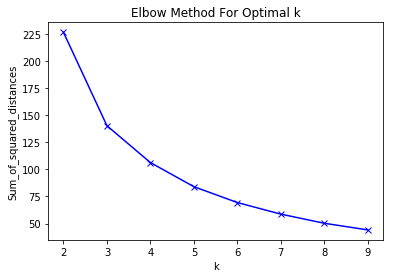

In [160]:
Sum_of_squared_distances = []
K = range(2,10)
for k in K:
    km = cluster.KMeans(n_clusters=k)
    km = km.fit(train_principalDf)
    Sum_of_squared_distances.append(km.inertia_)
    cluster_labels = km.labels_
    silhouette_avg = silhouette_score(train_principalDf, cluster_labels)
    print("For n_clusters =", k,
          "The average silhouette_score is :", silhouette_avg)
    
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [161]:
k = 6
kmeans = cluster.KMeans(n_clusters=k)
kmeans.fit(train_principalDf)

train_labels = kmeans.predict(train_principalDf)
test_labels = kmeans.predict(test_principalDf)

train_principalDf['Team'] = train_ros_comp_team_stats['Team']
train_principalDf['Cluster'] = train_labels
train_principalDf = train_principalDf.drop_duplicates()

test_principalDf['Team'] = test_ros_comp_team_stats['Team']
test_principalDf['Cluster'] = test_labels
test_principalDf = test_principalDf.drop_duplicates()

In [162]:
test_principalDf

,principal component 1,principal component 2,Team,Cluster
0,1.053651,0.572533,Atlanta Hawks/2019,1
1,-1.856802,1.998182,Boston Celtics/2019,0
2,2.467274,0.688453,Brooklyn Nets/2019,1
4,0.773758,0.597770,Charlotte Hornets/2019,5
6,-1.003115,1.841783,Chicago Bulls/2019,0
7,-2.417598,1.385475,Cleveland Cavaliers/2019,0
8,1.258792,0.593773,Dallas Mavericks/2019,1
9,-0.947625,2.211658,Denver Nuggets/2019,0
10,0.513806,1.740440,Detroit Pistons/2019,3
11,-1.067091,2.136212,Golden State Warriors/2019,0


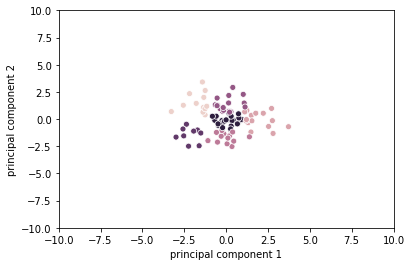

In [163]:
plt.figure()
plt.ylim(-10, 10)
plt.xlim(-10, 10)
sns.scatterplot(x='principal component 1', y ='principal component 2', hue ="Cluster", data = train_principalDf, legend = False )


In [166]:
train_teams_clustered = train_ros_comp_team_stats.merge(train_principalDf, left_on = 'Team', right_on = 'Team')
test_teams_clustered = test_ros_comp_team_stats.merge(test_principalDf, left_on = 'Team', right_on = 'Team')

train_teams_clustered['Year'] = train_teams_clustered.apply(lambda row: row.Team.split('/')[1], axis=1)
test_teams_clustered['Year'] = test_teams_clustered.apply(lambda row: row.Team.split('/')[1], axis=1)

train_teams_clustered = train_teams_clustered.merge(train_teams[['W', 'Team_year', 'Playoffs']], left_on = 'Team', right_on = 'Team_year')
test_teams_clustered = test_teams_clustered.merge(test_teams[['W', 'Team_year', 'Playoffs']], left_on = 'Team', right_on = 'Team_year')

train_teams_clustered = train_teams_clustered.drop_duplicates()
test_teams_clustered = test_teams_clustered.drop_duplicates()

train_teams_clustered = train_teams_clustered.drop(['Team_year_x', 'Team_year_y'], axis = 1)
test_teams_clustered = test_teams_clustered.drop(['Team_year_x', 'Team_year_y'], axis = 1)

train_teams_clustered.to_csv('train_teams_roster_clustered.csv')
test_teams_clustered.to_csv('test_teams_roster_clustered.csv')

all_teams_clustered = train_teams_clustered.append(test_teams_clustered)
all_teams_clustered.to_csv('all_teams_roster_clustered.csv')

In [167]:
test_teams_clustered

,3 & D Wing,Combo Guard,Defensive Forward,Offensive Big Man,Pace & Space Forward,Post-Heavy Big Man,Primary Distributing Ballhandler,Slashing Guard,Team,3PAr,FTr,Pace,principal component 1,principal component 2,Cluster,Year,W,Playoffs
0,0,1,2,0,0,1,5,0,Atlanta Hawks/2019,0.403,0.255,103.9,1.053651,0.572533,1,2019,29.0,0
1,2,0,3,0,1,0,3,0,Boston Celtics/2019,0.381,0.215,99.6,-1.856802,1.998182,0,2019,49.0,1
2,0,2,1,2,1,1,2,0,Brooklyn Nets/2019,0.403,0.284,100.8,2.467274,0.688453,1,2019,42.0,1
6,0,0,0,0,0,0,0,0,Charlotte Hornets/2019,0.378,0.257,98.7,0.773758,0.597770,5,2019,39.0,0
10,2,0,1,0,2,1,3,0,Chicago Bulls/2019,0.295,0.235,99.0,-1.003115,1.841783,0,2019,22.0,0
11,3,0,3,0,0,0,3,0,Cleveland Cavaliers/2019,0.332,0.236,96.6,-2.417598,1.385475,0,2019,19.0,0
12,0,0,1,1,2,1,4,0,Dallas Mavericks/2019,0.422,0.291,99.0,1.258792,0.593773,1,2019,33.0,0
13,2,0,1,1,2,0,3,0,Denver Nuggets/2019,0.348,0.232,97.7,-0.947625,2.211658,0,2019,54.0,1
14,1,1,1,1,3,1,1,0,Detroit Pistons/2019,0.394,0.262,97.4,0.513806,1.740440,3,2019,41.0,1
15,2,0,3,1,1,0,2,0,Golden State Warriors/2019,0.384,0.227,100.9,-1.067091,2.136212,0,2019,57.0,1
